# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import xarray as xr
import numpy as np

In [2]:
data_dir = '/data/roshan/Segmentation1/deepcell_output_138_reordered.nc'
loaded = xr.open_dataarray(data_dir)

In [3]:
import os
import errno
import numpy as np
import deepcell
from deepcell import model_zoo

### Load the training data

In [2]:
# create folder for this set of experiments
experiment_folder = "20191113_Decidua_Shirley_Relabel/"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
npz_name = "Decidua_Caliban_V3_blanked_stride_0.5"
training_data = np.load(NPZ_DIR + npz_name +".npz")
(X_train, y_train) = training_data["X"], training_data["y"]

print('X_train.shape: {}\ny_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (1024, 256, 256, 6)
y_train.shape: (1024, 256, 256, 1)


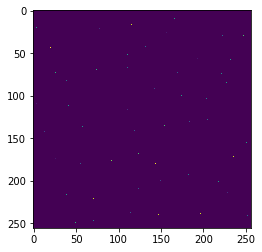

In [12]:
import matplotlib.pyplot as plt
plt.imshow(X_train[200, :, :, 4])

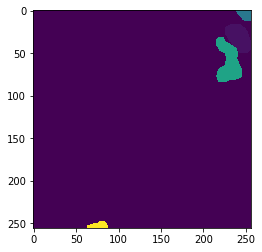

In [13]:
import matplotlib.pyplot as plt
plt.imshow(y_train[200, :, :, 0])

### Set up filepath constants

In [9]:
# the path to the data file is currently required for `train_model_()` functions
DATA_FILE = os.path.join(NPZ_DIR, npz_name + ".npz")

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

### Set up training parameters

In [14]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler


n_epoch = 6 # Number of training epochs
norm_method = 'std'  # data normalization
receptive_field = 101  # should be adjusted for the scale of the data
n_conv_filters = 128
n_dense_filters = 512

conv_model_name = npz_name + '_convolutional_{}_rf_{}_dense_{}_conv'.format(receptive_field, n_dense_filters, n_conv_filters)

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)
test_size = 0.05
seed=0

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'pixelwise'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = False  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

### Create a model for the edge/interior segmentation

#### Instantiate the segmentation transform model

In [15]:
conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=n_conv_filters,
    n_dense_filters=n_dense_filters,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

W0119 20:34:11.842609 140031091398464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
conv_model_name

'Decidua_Caliban_V3_blanked_stride_0.5_convolutional_101_rf_512_dense_128_conv'

#### Train the segmentation transform model

In [17]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    seed=seed,
    transform=transform,
    dilation_radius=dilation_radius,
    separate_edge_classes=separate_edge_classes,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),)

X_train shape: (972, 256, 256, 6)
y_train shape: (972, 256, 256, 1)
X_test shape: (52, 256, 256, 6)
y_test shape: (52, 256, 256, 1)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Training on 1 GPUs
Epoch 1/6


W0119 20:35:40.362806 140031091398464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


971/972 [============================>.] - ETA: 0s - loss: 3.1131 - model_loss: 0.7389 - model_1_loss: 0.7345 - model_2_loss: 0.7393 - model_3_loss: 0.7364 - model_acc: 0.7088 - model_1_acc: 0.7108 - model_2_acc: 0.7093 - model_3_acc: 0.7098
Epoch 00001: val_loss improved from inf to 3.08745, saving model to /data/models/20191113_Decidua_Shirley_Relabel/Decidua_Caliban_V3_blanked_stride_0.5_convolutional_101_rf_512_dense_128_conv.h5
972/972 [==============================] - 610s 627ms/step - loss: 3.1120 - model_loss: 0.7387 - model_1_loss: 0.7342 - model_2_loss: 0.7390 - model_3_loss: 0.7361 - model_acc: 0.7089 - model_1_acc: 0.7109 - model_2_acc: 0.7094 - model_3_acc: 0.7099 - val_loss: 3.0875 - val_model_loss: 0.7235 - val_model_1_loss: 0.7412 - val_model_2_loss: 0.7694 - val_model_3_loss: 0.6895 - val_model_acc: 0.7528 - val_model_1_acc: 0.7484 - val_model_2_acc: 0.7249 - val_model_3_acc: 0.7689
Epoch 2/6
971/972 [============================>.] - ETA: 0s - loss: 2.7373 - model_lo

KeyboardInterrupt: 

### Run the model

#### Make predictions on test data

In [14]:
#test_data = np.load(NPZ_DIR + "lab_combined_h3_test.npz")
test_data = np.load('/data/npz_data/lab_combined_test_nolamin.npz')
(X_test, y_test) = test_data["X"], test_data["y"]

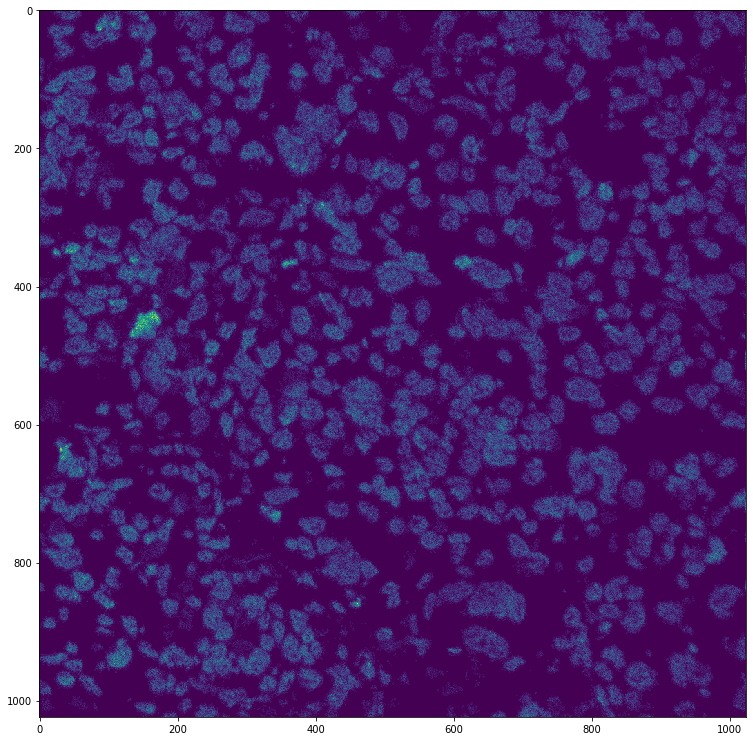

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(X_test[0, :, :, 0])

In [21]:
weights_path = os.path.join(MODEL_DIR, conv_model_name + "_epoch3.h5")
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=128,
    n_dense_filters=512,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]))

run_conv_model.load_weights(weights_path)

In [22]:
test_images_conv = run_conv_model.predict(X_test[0:1, :, :, :])[-1]

#### Post-processing

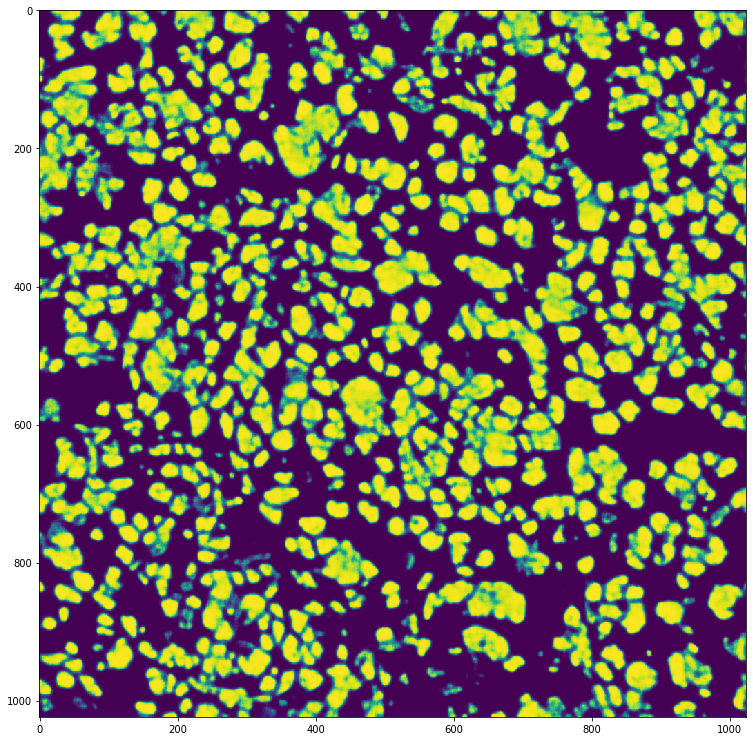

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

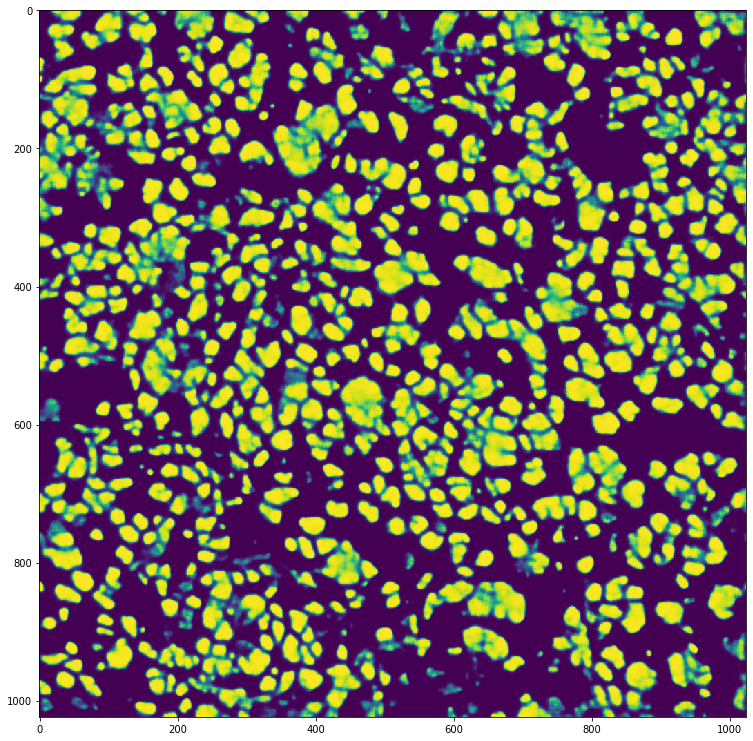

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

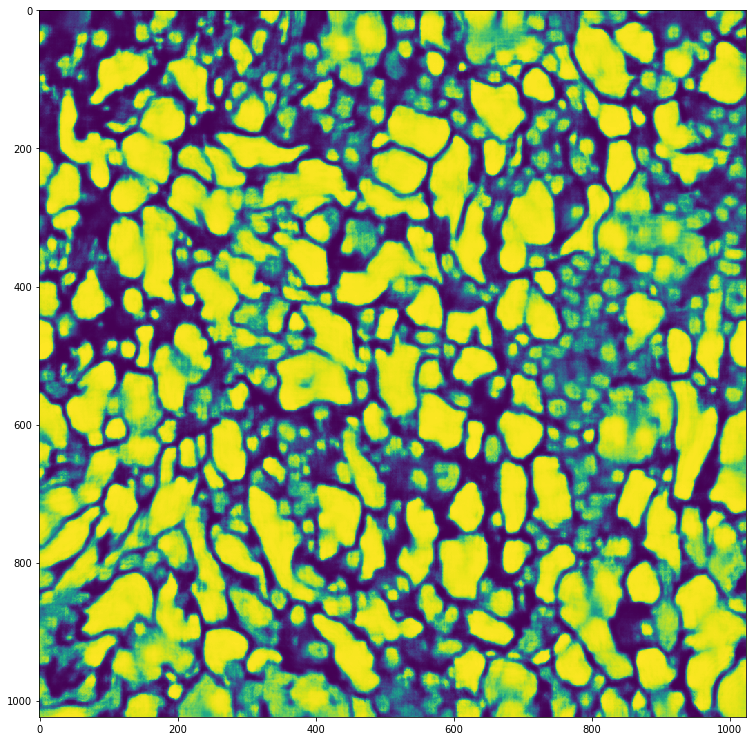

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(test_images_conv[0, :, :, 0])